# Magic : The Gathering Card Detection

## Imports

In [2]:
# Import required packages
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import json
import re
import imutils
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Mention the installed location of Tesseract-OCR in system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\tesseractOCR\tesseract.exe'

## Apply a perspective transform to rectify the image

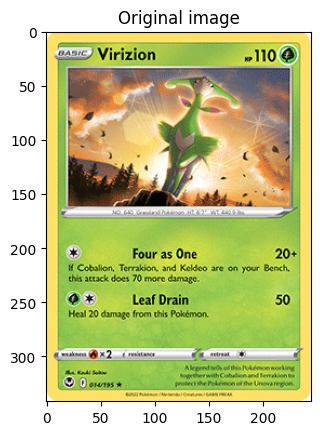

In [39]:
img_name = '3' # Change this to the name of the image you want to read and run the cells below (except for the creation of the model)

# Read image in either png or jpg format
img = cv2.imread('./cards/' + img_name + '.jpg')
if img is None:
    img = cv2.imread('./cards/' + img_name + '.png')

plt.title('Original image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Detect text

In [40]:
text = pytesseract.image_to_string(img)
print(text)

Four as One 20+
WH Cobsion,Teraton and Kalo are on your Boh,
(hese docs TO more cigs.

@* Leaf Drain 50
Hes 20 cage em hs Potton




## Create the model

In [31]:
# Load the "cards.json" file into a pandas dataframe
with open('./data/cards.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data)

# Preprocess the text data
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        # Remove accents
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        if not text:
            return ''
        return text
    return ''   

df['name_preprocessed'] = df['name'].apply(preprocess_text)
df['attacks_preprocessed'] = df['attacks'].apply(preprocess_text)

# Create TF-IDF vectorizers
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the preprocessed text data
corpus = df['name_preprocessed'] + ' ' + df['attacks_preprocessed']
vectorizer.fit(corpus)

TfidfVectorizer()

## Find card

In [41]:
# Define a function to find the closest matches to the input text
def find_closest_match(input_text, vectorizer):
    input_text = preprocess_text(input_text)
    input_vector = vectorizer.transform([input_text])
    similarities = cosine_similarity(input_vector, vectorizer.transform(corpus))

    # Get the 5 closest matches that have different ids
    closest_match_ids = []
    while len(closest_match_ids) < 5:
        closest_match_id = df.iloc[np.argmax(similarities)]['id']
        if closest_match_id not in closest_match_ids:
            closest_match_ids.append(closest_match_id)
        similarities[0, np.argmax(similarities)] = 0

    return closest_match_ids

# Use the function to find the closest match to the input text and return the corresponding 'id'
input_text = text
closest_match_id = find_closest_match(input_text, vectorizer)

print("Top 5 closest matches :")
print("1: " + df[df['id'] == closest_match_id[0]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[0]]['attacks'].values[0])
print("2: " + df[df['id'] == closest_match_id[1]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[1]]['attacks'].values[0])
print("3: " + df[df['id'] == closest_match_id[2]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[2]]['attacks'].values[0])
print("4: " + df[df['id'] == closest_match_id[3]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[3]]['attacks'].values[0])
print("5: " + df[df['id'] == closest_match_id[4]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[4]]['attacks'].values[0])
print("")

Top 5 closest matches :
1: Virizion - [{'name': 'Four as One', 'cost': ['Colorless'], 'convertedEnergyCost': 1, 'damage': '20+', 'text': 'If Cobalion, Terrakion, and Keldeo are on your Bench, this attack does 70 more damage.'}, {'name': 'Leaf Drain', 'cost': ['Grass', 'Colorless'], 'convertedEnergyCost': 2, 'damage': '50', 'text': 'Heal 20 damage from this Pokémon.'}]
2: Keldeo - [{'name': 'Wave Splash', 'cost': ['Water'], 'convertedEnergyCost': 1, 'damage': '20', 'text': ''}, {'name': 'Four as One', 'cost': ['Water', 'Colorless', 'Colorless'], 'convertedEnergyCost': 3, 'damage': '50+', 'text': 'If Cobalion, Terrakion, and Virizion are on your Bench, this attack does 170 more damage.'}]
3: Sableye - [{'name': 'Scratch', 'cost': ['Colorless'], 'convertedEnergyCost': 1, 'damage': '10', 'text': ''}, {'name': 'Shadow Cage', 'cost': ['Psychic', 'Colorless'], 'convertedEnergyCost': 2, 'damage': '20', 'text': "The Defending Pokémon can't retreat during your opponent's next turn."}]
4: Absol -